<a href="https://colab.research.google.com/github/NobleezIT/30-Days-Of-Python/blob/master/Myproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [2]:
data_dir = "/content/drive/MyDrive/split_dataset"

train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")


In [3]:
image_size = 224  # Standard size for ResNet or other pretrained models

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [4]:
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
val_data = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [5]:
print("Classes:", train_data.classes)
print("Number of training images:", len(train_data))
print("Number of validation images:", len(val_data))
print("Number of test images:", len(test_data))


Classes: ['beans', 'groundnut', 'maize', 'millet']
Number of training images: 280
Number of validation images: 60
Number of test images: 60


In [8]:
import numpy as np
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # CHW to HWC
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')


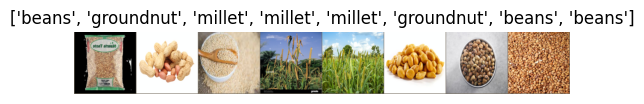

In [10]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from the batch
from torchvision.utils import make_grid
out = make_grid(inputs[:8])  # Display 8 images

# Show the images with labels
class_names = train_data.classes
imshow(out, title=[class_names[c] for c in classes[:8]])


In [15]:
import copy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [16]:
# 1. Load pretrained model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)


In [17]:
# 3. Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [18]:
# 4. Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [19]:
# 5. Training function with validation, early stopping and saving best model
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Check if this is the best model so far
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_model.pth')  # Save model
            print("✅ Model improved. Saving model.")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"No improvement. ({epochs_no_improve}/{patience})")

        # Early stopping
        if epochs_no_improve >= patience:
            print("\n🛑 Early stopping triggered.")
            break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [20]:
# 6. Train it!
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25, patience=5)


Epoch 1/25
--------------------


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train Loss: 1.3766 Acc: 0.3107
Val Loss: 1.1469 Acc: 0.5000
✅ Model improved. Saving model.

Epoch 2/25
--------------------
Train Loss: 1.0322 Acc: 0.6179
Val Loss: 0.9459 Acc: 0.6500
✅ Model improved. Saving model.

Epoch 3/25
--------------------
Train Loss: 0.8740 Acc: 0.6500
Val Loss: 0.7952 Acc: 0.7167
✅ Model improved. Saving model.

Epoch 4/25
--------------------
Train Loss: 0.7729 Acc: 0.7036
Val Loss: 0.7285 Acc: 0.7167
No improvement. (1/5)

Epoch 5/25
--------------------
Train Loss: 0.7197 Acc: 0.7393
Val Loss: 0.6988 Acc: 0.7000
No improvement. (2/5)

Epoch 6/25
--------------------
Train Loss: 0.6158 Acc: 0.7821
Val Loss: 0.6361 Acc: 0.7667
✅ Model improved. Saving model.

Epoch 7/25
--------------------
Train Loss: 0.5395 Acc: 0.8321
Val Loss: 0.5938 Acc: 0.7833
✅ Model improved. Saving model.

Epoch 8/25
--------------------
Train Loss: 0.5359 Acc: 0.8321
Val Loss: 0.5665 Acc: 0.8000
✅ Model improved. Saving model.

Epoch 9/25
--------------------
Train Loss: 0.4521 A

In [21]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
class_names = ['groundnut', 'beans', 'millet', 'maize']
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
print("\n🔲 Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))



📊 Classification Report:
              precision    recall  f1-score   support

   groundnut       0.71      0.67      0.69        15
       beans       0.73      0.73      0.73        15
      millet       1.00      0.87      0.93        15
       maize       0.72      0.87      0.79        15

    accuracy                           0.78        60
   macro avg       0.79      0.78      0.78        60
weighted avg       0.79      0.78      0.78        60


🔲 Confusion Matrix:
[[10  3  0  2]
 [ 2 11  0  2]
 [ 0  1 13  1]
 [ 2  0  0 13]]


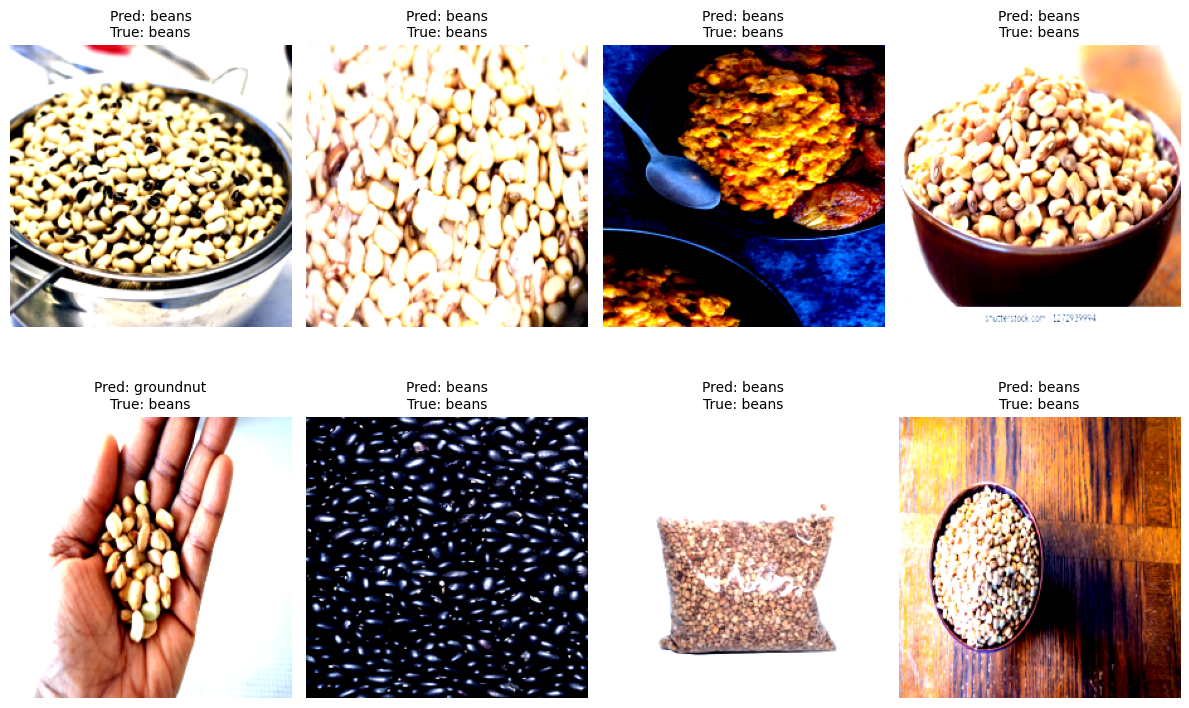

In [28]:
import matplotlib.pyplot as plt

class_names = ['beans','groundnut', 'maize', 'millet']

# Function to un-normalize and display images
def imshow(inp, title=None):
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])  # match your transforms.Normalize
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean  # unnormalize
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title, fontsize=10)
    plt.axis('off')

# Get a batch of test data
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

# Predict
outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Show images with predicted and true labels
plt.figure(figsize=(12, 8))
for i in range(8):  # Display 8 images
    ax = plt.subplot(2, 4, i + 1)
    imshow(inputs[i], title=f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
plt.tight_layout()
plt.show()
